In [1]:
#Import data set

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import glob

import os


import cv2
from PIL import Image
import math

## Mask detection model

#### Get the list of names of images and masks and name the list imagelist and masklist

In [2]:
img_path='F:\\GreatLearning\\AI\\ComputerVision\\Project2\\Part1\\training_images'
mask_path='F:\\GreatLearning\\AI\\ComputerVision\\Project2\\Part1\\masks'

imagelist = os.listdir(img_path)
masklist = os.listdir(mask_path)

In [3]:
#Sorting
imagelist.sort()
masklist.sort()

In [4]:
#Test your list names by printing some of the names as given below.
print(imagelist[-1])
print(masklist[-1])
print(imagelist[10])
print(masklist[10])

img0099.PNG
img0099.PNG
img00107.PNG
img00107.PNG


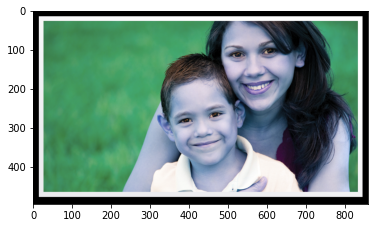

In [5]:
plt.imshow(cv2.imread('F:\\GreatLearning\\AI\\ComputerVision\\Project2\\Part1\\training_images\\{}'.format(imagelist[59])))

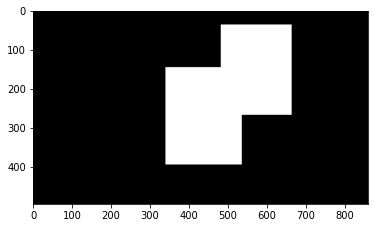

In [6]:
plt.imshow(cv2.imread('F:\\GreatLearning\\AI\\ComputerVision\\Project2\\Part1\\masks\\{}'.format(masklist[59])))

In [7]:
#Image Settings -

IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

In [8]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from keras.layers.normalization import BatchNormalization
from tensorflow.keras import layers


import segmentation_models
segmentation_models.set_framework('tf.keras')
from segmentation_models.backbones.backbones_factory import Backbones

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import binary_crossentropy

import tensorflow
tensorflow.__version__

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


'2.1.0'

In [9]:
img_path='F:\\GreatLearning\\AI\\ComputerVision\\Project2\\Part1\\training_images'
mask_path='F:\\GreatLearning\\AI\\ComputerVision\\Project2\\Part1\\masks'

imagelist = os.listdir(img_path)
masklist = os.listdir(mask_path)

In [10]:
img_path='F:/GreatLearning/AI/ComputerVision/Project2/Part1/training_images/'
mask_path='F:/GreatLearning/AI/ComputerVision/Project2/Part1/masks/'

In [11]:
import numpy as np

im_height =128
im_width = 128

# Get and resize train images and masks
def get_data(train=True):
    #ids = next(os.walk("train/images"))[2]
    X = np.zeros((len(imagelist), im_height, im_width, 1), dtype=np.float32)
    y = np.zeros((len(masklist), im_height, im_width, 1), dtype=np.float32)
    for n in imagelist:
        k = imagelist.index(n)
        image_path = os.path.join('F:/GreatLearning/AI/ComputerVision/Project2/Part1/training_images/' +n )
        mask_path = os.path.join('F:/GreatLearning/AI/ComputerVision/Project2/Part1/masks/' +n )
        #print(image_path)
        
        # Load images
        img = cv2.imread(image_path, 0)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized_img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
        

        # Load masks
        if train:
            mask = cv2.imread(mask_path, 0)
            resized_mask = cv2.resize(mask, (128, 128), interpolation = cv2.INTER_AREA)
            resized_mask = np.reshape(resized_mask, (128,128,1))
            
           

        # Save images
        X[k, ..., 0] = resized_img.squeeze() / 255
        if train:
            #y[k] = resized_mask/255
            #prob
            resized_mask = resized_mask/255
            resized_mask[resized_mask > 0.5] = 1
            resized_mask[resized_mask <= 0.5] = 0
            y[k] = resized_mask
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(train=True)

Done!


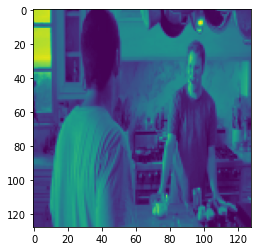

In [12]:
#Check the images
plt.imshow(X[1])

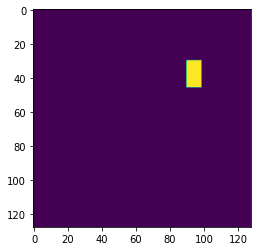

In [13]:
#Check the images
plt.imshow(y[1])

In [14]:
X[1].shape

(128, 128, 1)

- Creating Models

In [15]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)


In [16]:
from sklearn.model_selection import train_test_split

# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

In [17]:
y_train.shape

(347, 128, 128, 1)

In [18]:
# preprocess input
X_train = preprocess_input(X_train)
X_valid = preprocess_input(X_valid)


In [19]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.math.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

In [20]:
def soft_dice(y_pred, y_true):
    # y_pred is softmax output of shape (num_samples, num_classes)
    # y_true is one hot encoding of target (shape= (num_samples, num_classes))
    intersect = tensorflow.reduce_sum(y_pred * y_true, 0)
    denominator = tensorflow.reduce_sum(y_pred, 0) + tensorflow.reduce_sum(y_true, 0)
    dice_scores = 2 * intersect / (denominator + tensorflow.keras.backend.epsilon())
    return dice_scores

In [21]:
model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None, None, 1))

In [22]:
model.compile(optimizer='Adam', loss=loss, metrics=[soft_dice])

In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 1 3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 1 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 3136        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [24]:
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath='mdl_callback.hdf5',
    save_weights_only=True,
    monitor='val_soft_dice',
    mode='max',
    save_best_only=True)

In [25]:

model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,   
    epochs=10,
    validation_data=(X_valid, y_valid),
    callbacks=[model_checkpoint_callback]
    )

Train on 347 samples, validate on 62 samples
Epoch 1/10
347/347 [==============================] - 126s 364ms/sample - loss: 1.8978 - soft_dice: 0.1917 - val_loss: 1502216.3266 - val_soft_dice: 1.3191e-04
Epoch 2/10
347/347 [==============================] - 112s 322ms/sample - loss: 1.4578 - soft_dice: 0.2075 - val_loss: 136680.2598 - val_soft_dice: 0.0132
Epoch 3/10
347/347 [==============================] - 113s 325ms/sample - loss: 1.2671 - soft_dice: 0.2335 - val_loss: 12421.3544 - val_soft_dice: 0.1805
Epoch 4/10
347/347 [==============================] - 110s 318ms/sample - loss: 1.1728 - soft_dice: 0.2427 - val_loss: 372.2660 - val_soft_dice: 0.1343
Epoch 5/10
347/347 [==============================] - 111s 321ms/sample - loss: 1.0288 - soft_dice: 0.2789 - val_loss: 351.1601 - val_soft_dice: 0.1901
Epoch 6/10
347/347 [==============================] - 110s 318ms/sample - loss: 0.9303 - soft_dice: 0.3095 - val_loss: 132.7638 - val_soft_dice: 0.0091
Epoch 7/10
347/347 [==========

In [26]:
#Save weights
from tensorflow.keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("part1_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("part1_model.h5")
print("Saved model to disk")

Saved model to disk


In [27]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

import numpy as np

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.3).astype(np.uint8)

62/62 [==============================] - 4s 57ms/sample


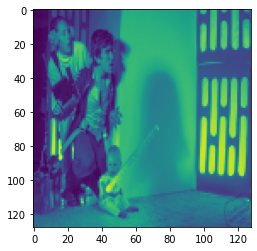

In [28]:
plt.imshow(X_train[3])

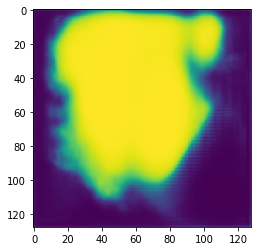

In [29]:
plt.imshow(preds_train[3])

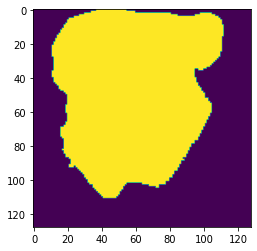

In [30]:
plt.imshow(preds_train_t[3])

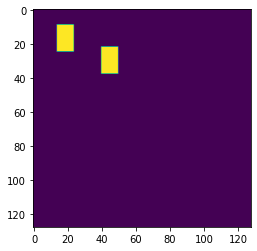

In [31]:
plt.imshow(y_train[3])

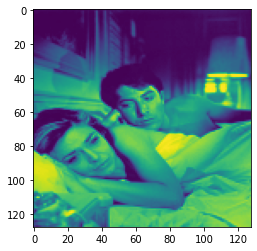

In [32]:
plt.imshow(X_valid[50])

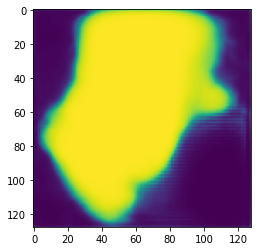

In [33]:
plt.imshow(preds_val[50])

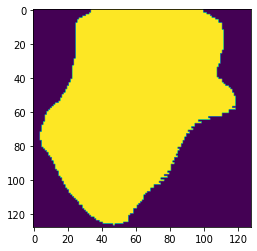

In [34]:
plt.imshow(preds_val_t[50])

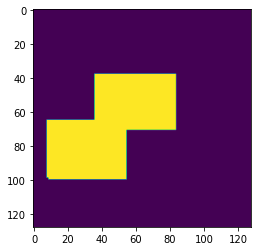

In [35]:
plt.imshow(y_valid[50])

- We can see model is able to identify the whole bigger area of faces but not to a accurate locations

- Reimporting images for image augmentions and try tht out

In [36]:
import numpy as np

im_height =128
im_width = 128

# Get and resize train images and masks
def get_data(train=True):
    #ids = next(os.walk("train/images"))[2]
    X = np.zeros((len(imagelist), im_height, im_width, 3), dtype=np.float32)
    y = np.zeros((len(masklist), im_height, im_width, 1), dtype=np.float32)
    for n in imagelist:
        k = imagelist.index(n)
        image_path = os.path.join('F:/GreatLearning/AI/ComputerVision/Project2/Part1/training_images/' +n )
        mask_path = os.path.join('F:/GreatLearning/AI/ComputerVision/Project2/Part1/masks/' +n )
        #print(image_path)
        
        # Load images
        img = cv2.imread(image_path, 0)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized_img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
        

        # Load masks
        if train:
            mask = cv2.imread(mask_path, 0)
            resized_mask = cv2.resize(mask, (128, 128), interpolation = cv2.INTER_AREA)
            resized_mask = np.reshape(resized_mask, (128,128,1))
            
           

        # Save images
        X[k, ..., 0] = resized_img.squeeze() / 255
        if train:
            #y[k] = resized_mask/255
            #prob
            resized_mask = resized_mask/255
            resized_mask[resized_mask > 0.5] = 1
            resized_mask[resized_mask <= 0.5] = 0
            y[k] = resized_mask
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(train=True)

Done!


In [37]:
from sklearn.model_selection import train_test_split

# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

In [38]:
# image augmentation for train set and image resizing for validation & test
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( 
      #rescale=1./255,
      rotation_range=90,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator() 

train_batchsize = 10
val_batchsize = 10
 
train_generator = train_datagen.flow( 
        X_train,y_train,
        batch_size=train_batchsize,shuffle=False)
 
validation_generator = validation_datagen.flow(
        X_valid,y_valid,
        batch_size=val_batchsize,
        shuffle=False)


In [39]:
#mobilenetv2
N = X_train.shape[-1]
N

3

In [40]:


base_model = Unet(backbone_name='mobilenetv2', encoder_weights='imagenet')


inp = Input(shape=(128, 128, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)
l2 = Conv2D(1, (1, 1))(out)



model1 = Model(inp, l2, name=base_model.name)

model1.summary()

C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 3)       12        
_________________________________________________________________
model_2 (Model)              multiple                  8047441   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 1)       2         
Total params: 8,047,455
Trainable params: 8,011,359
Non-trainable params: 36,096
_________________________________________________________________


In [41]:
model1.compile(optimizer='Adam', loss=loss, metrics=[soft_dice])

In [42]:
model1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 3)       12        
_________________________________________________________________
model_2 (Model)              multiple                  8047441   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 1)       2         
Total params: 8,047,455
Trainable params: 8,011,359
Non-trainable params: 36,096
_________________________________________________________________


In [43]:
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath='mdl3_callback.hdf5',
    save_weights_only=True,
    monitor='val_soft_dice',
    mode='max',
    save_best_only=True)

In [44]:
history = model1.fit_generator(
      train_generator,
      steps_per_epoch=int(X_train.shape[0]/train_generator.batch_size) ,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=int(X_valid.shape[0]/validation_generator.batch_size))

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 34 steps, validate for 6 steps
Epoch 1/10
34/34 [==============================] - 111s 3s/step - loss: nan - soft_dice: 0.3627 - val_loss: 3.2100 - val_soft_dice: 0.4294
Epoch 2/10
34/34 [==============================] - 107s 3s/step - loss: nan - soft_dice: -0.1672 - val_loss: 3.2579 - val_soft_dice: 0.4183
Epoch 3/10
34/34 [==============================] - 104s 3s/step - loss: nan - soft_dice: 0.3218 - val_loss: 3.2720 - val_soft_dice: 0.4179
Epoch 4/10
34/34 [==============================] - 105s 3s/step - loss: nan - soft_dice: 0.0271 - val_loss: 2.4144 - val_soft_dice: 6.8464
Epoch 5/10
34/34 [==============================] - 97s 3s/step - loss: 2.1075 - soft_dice: 0.2721 - val_loss: 2.6311 - val_soft_dice: 0.6030
Epoch 6/10
34/34 [==============================] - 99s 3s/step - loss: 1.7411 - soft_dice: 0.2247 - val_loss: 2.6506 - val_soft_d

In [45]:
#Save weights
from tensorflow.keras.models import model_from_json

# serialize model to JSON
model_json = model1.to_json()
with open("part1_model3.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("part1_model3.h5")
print("Saved model to disk")

Saved model to disk


In [46]:
# Predict on train, val and test
preds_train = model1.predict(X_train, verbose=1)
preds_val = model1.predict(X_valid, verbose=1)

import numpy as np

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

62/62 [==============================] - 2s 35ms/sample


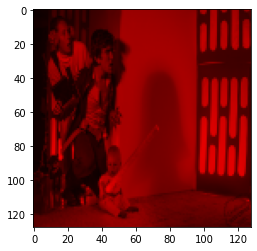

In [47]:
plt.imshow(X_train[3])

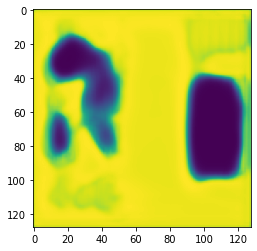

In [48]:
plt.imshow(preds_train[3])

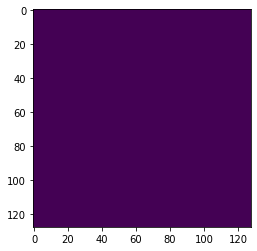

In [49]:
plt.imshow(preds_train_t[3])

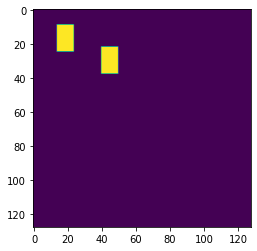

In [50]:
plt.imshow(y_train[3])

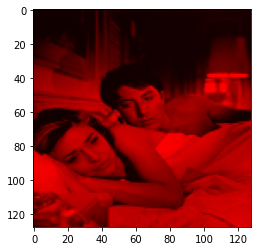

In [51]:
plt.imshow(X_valid[50])

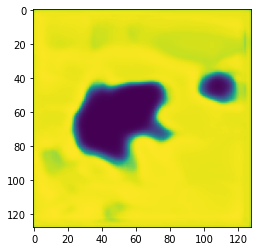

In [52]:
plt.imshow(preds_val[50])

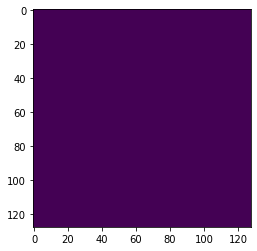

In [53]:
plt.imshow(preds_val_t[50])

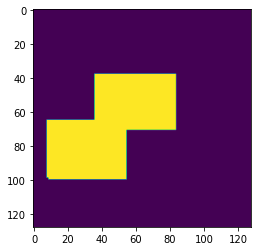

In [54]:
plt.imshow(y_valid[50])

- We were trying out with less epochs for initial analysis which could imapct the initial views
- with augmented images we can see some improvemetns on isolation of faces

In [55]:
#Running for more epochs

In [56]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from keras.layers.normalization import BatchNormalization
from tensorflow.keras import layers


import segmentation_models
segmentation_models.set_framework('tf.keras')
from segmentation_models.backbones.backbones_factory import Backbones

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import binary_crossentropy

import tensorflow
tensorflow.__version__

'2.1.0'

In [57]:
img_path='F:\\GreatLearning\\AI\\ComputerVision\\Project2\\Part1\\training_images'
mask_path='F:\\GreatLearning\\AI\\ComputerVision\\Project2\\Part1\\masks'

imagelist = os.listdir(img_path)
masklist = os.listdir(mask_path)

In [58]:
img_path='F:/GreatLearning/AI/ComputerVision/Project2/Part1/training_images/'
mask_path='F:/GreatLearning/AI/ComputerVision/Project2/Part1/masks/'

In [59]:
import numpy as np

im_height =128
im_width = 128

# Get and resize train images and masks
def get_data(train=True):
    #ids = next(os.walk("train/images"))[2]
    X = np.zeros((len(imagelist), im_height, im_width, 1), dtype=np.float32)
    y = np.zeros((len(masklist), im_height, im_width, 1), dtype=np.float32)
    for n in imagelist:
        k = imagelist.index(n)
        image_path = os.path.join('F:/GreatLearning/AI/ComputerVision/Project2/Part1/training_images/' +n )
        mask_path = os.path.join('F:/GreatLearning/AI/ComputerVision/Project2/Part1/masks/' +n )
        #print(image_path)
        
        # Load images
        img = cv2.imread(image_path, 0)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized_img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
        

        # Load masks
        if train:
            mask = cv2.imread(mask_path, 0)
            resized_mask = cv2.resize(mask, (128, 128), interpolation = cv2.INTER_AREA)
            resized_mask = np.reshape(resized_mask, (128,128,1))
            
           

        # Save images
        X[k, ..., 0] = resized_img.squeeze() / 255
        if train:
            y[k] = resized_mask/255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(train=True)

Done!


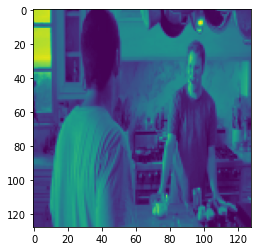

In [60]:
#Check the images
plt.imshow(X[1])

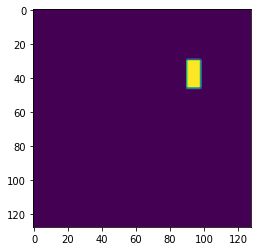

In [61]:
#Check the images
plt.imshow(y[1])

In [62]:
X[1].shape

(128, 128, 1)

In [63]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)


In [64]:
from sklearn.model_selection import train_test_split

# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

In [65]:
y_train.shape

(347, 128, 128, 1)

In [66]:
# preprocess input
X_train = preprocess_input(X_train)
X_valid = preprocess_input(X_valid)


In [67]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.math.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

In [68]:
def soft_dice(y_pred, y_true):
    # y_pred is softmax output of shape (num_samples, num_classes)
    # y_true is one hot encoding of target (shape= (num_samples, num_classes))
    intersect = tensorflow.reduce_sum(y_pred * y_true, 0)
    denominator = tensorflow.reduce_sum(y_pred, 0) + tensorflow.reduce_sum(y_true, 0)
    dice_scores = 2 * intersect / (denominator + tensorflow.keras.backend.epsilon())
    return dice_scores

In [69]:
model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None, None, 1))

In [70]:
model.compile(optimizer='Adam', loss=loss, metrics=[soft_dice])

In [71]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 1 3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_34 (ZeroPadding2 (None, None, None, 1 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 3136        zero_padding2d_34[0][0]          
____________________________________________________________________________________________

__________________________________________________________________________________________________
add_31 (Add)                    (None, None, None, 5 0           stage4_unit3_conv2[0][0]         
                                                                 add_30[0][0]                     
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, None, None, 5 2048        add_31[0][0]                     
__________________________________________________________________________________________________
relu1 (Activation)              (None, None, None, 5 0           bn1[0][0]                        
__________________________________________________________________________________________________
decoder_stage0_upsampling (UpSa (None, None, None, 5 0           relu1[0][0]                      
__________________________________________________________________________________________________
decoder_st

In [72]:
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath='mdl_callback_final.hdf5',
    save_weights_only=True,
    monitor='val_soft_dice',
    mode='max',
    save_best_only=True)

In [73]:

model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,   
    epochs=10,
    validation_data=(X_valid, y_valid),
    callbacks=[model_checkpoint_callback]
    )

Train on 347 samples, validate on 62 samples
Epoch 1/10
347/347 [==============================] - 131s 376ms/sample - loss: 1.8842 - soft_dice: 0.1819 - val_loss: 654.7272 - val_soft_dice: 0.0046
Epoch 2/10
347/347 [==============================] - 114s 328ms/sample - loss: 1.4799 - soft_dice: 0.2077 - val_loss: 3411.3423 - val_soft_dice: 0.2173
Epoch 3/10
347/347 [==============================] - 112s 324ms/sample - loss: 1.3060 - soft_dice: 0.2309 - val_loss: 74.7492 - val_soft_dice: 0.2141
Epoch 4/10
347/347 [==============================] - 112s 324ms/sample - loss: 1.1276 - soft_dice: 0.2602 - val_loss: 16.6272 - val_soft_dice: 0.2171
Epoch 5/10
347/347 [==============================] - 112s 322ms/sample - loss: 1.0203 - soft_dice: 0.2832 - val_loss: 15.3507 - val_soft_dice: 0.2084
Epoch 6/10
347/347 [==============================] - 112s 322ms/sample - loss: 0.9228 - soft_dice: 0.3097 - val_loss: 11.6005 - val_soft_dice: 0.2052
Epoch 7/10
347/347 [==========================

In [74]:
#Save weights
from tensorflow.keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("part1_model_final.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("part1_model_final.h5")
print("Saved model to disk")

Saved model to disk


In [75]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

import numpy as np

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.3).astype(np.uint8)

62/62 [==============================] - 3s 54ms/sample


In [76]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

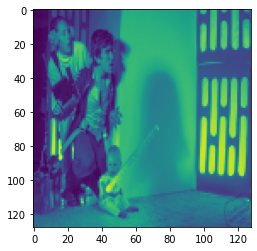

In [77]:
plt.imshow(X_train[3])

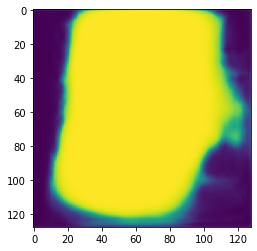

In [78]:
plt.imshow(preds_train[3])

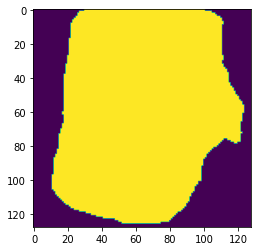

In [79]:
plt.imshow(preds_train_t[3])

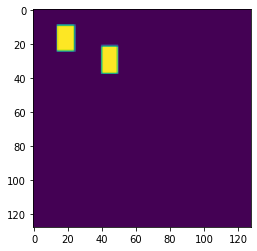

In [80]:
plt.imshow(y_train[3])

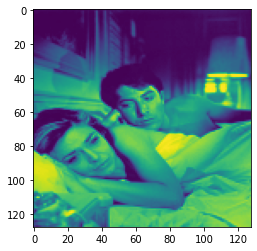

In [81]:
plt.imshow(X_valid[50])

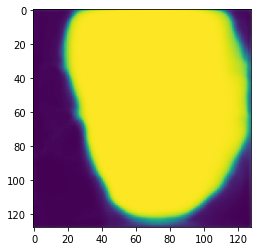

In [82]:
plt.imshow(preds_val[50])

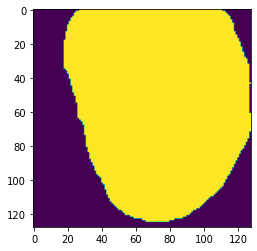

In [83]:
plt.imshow(preds_val_t[50])

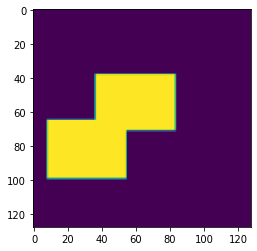

In [84]:
plt.imshow(y_valid[50])

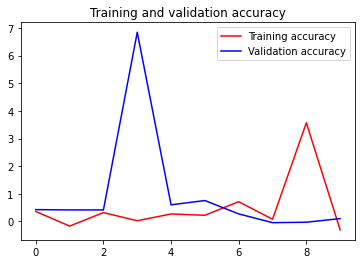

<Figure size 432x288 with 0 Axes>

In [85]:
acc = history.history['soft_dice']
val_acc = history.history['val_soft_dice']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

- Traing and validation accuracies are not improved with multiple iterations
- This model is too simple to learn te complexities

In [1]:
#Trying out Moble net and re importing data s it require 224x224

#References
#https://www.kaggle.com/mistag/train-keras-u-net-mobilenetv2
# The U-Net model Code snippet from UNET Segmentation with Pretrained MobileNetV2 as Encoder.
# https://idiotdeveloper.com/unet-segmentation-with-pretrained-mobilenetv2-as-encoder/

In [2]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from keras.layers.normalization import BatchNormalization
from tensorflow.keras import layers


import segmentation_models
segmentation_models.set_framework('tf.keras')
from segmentation_models.backbones.backbones_factory import Backbones

from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import binary_crossentropy

import tensorflow
tensorflow.__version__

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


'2.1.0'

In [53]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [54]:
import os

In [55]:
img_path='F:\\GreatLearning\\AI\\ComputerVision\\Project2\\Part1\\training_images'
mask_path='F:\\GreatLearning\\AI\\ComputerVision\\Project2\\Part1\\masks'

imagelist = os.listdir(img_path)
masklist = os.listdir(mask_path)

In [56]:
img_path='F:/GreatLearning/AI/ComputerVision/Project2/Part1/training_images/'
mask_path='F:/GreatLearning/AI/ComputerVision/Project2/Part1/masks/'

In [57]:
import numpy as np

im_height =224
im_width = 224
im_size =224

# Get and resize train images and masks
def get_data(train=True):
    #ids = next(os.walk("train/images"))[2]
    X = np.zeros((len(imagelist), im_size, im_size, 3), dtype=np.float32)
    y = np.zeros((len(masklist), im_size, im_size, 1), dtype=np.float32)
    for n in imagelist:
        k = imagelist.index(n)
        
        image_path = os.path.join('F:/GreatLearning/AI/ComputerVision/Project2/Part1/training_images/' +n )
        mask_path = os.path.join('F:/GreatLearning/AI/ComputerVision/Project2/Part1/masks/' +n )
        #print(image_path)
        
        # Load images
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resized_img = cv2.resize(img, (im_size, im_size))#, interpolation = cv2.INTER_AREA)
        

        # Load masks
        if train:
            mask = cv2.imread(mask_path,  cv2.IMREAD_GRAYSCALE)
            resized_mask = cv2.resize(mask, (im_size, im_size))#, interpolation = cv2.INTER_AREA)
            resized_mask = np.reshape(resized_mask, (im_size,im_size,1))
            
           

        # Save images
        X[k] = resized_img / 255.0
        if train:
            y[k] = resized_mask/255.0
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(train=True)

Done!


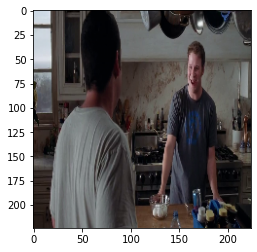

In [58]:
#Check the images
plt.imshow(X[1])

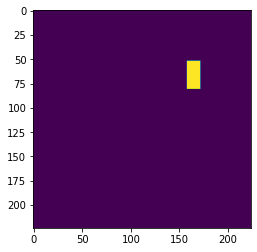

In [59]:
#Check the images
plt.imshow(y[1])

In [60]:
X[1].shape

(224, 224, 3)

In [61]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)


In [62]:
from sklearn.model_selection import train_test_split

# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

In [63]:
y_train.shape

(347, 224, 224, 1)

In [64]:
# preprocess input
X_train = preprocess_input(X_train)
X_valid = preprocess_input(X_valid)


###### Sample Image & Mask downloaded

In [65]:
# image augmentation for train set and image resizing for validation & test


In [66]:
np.random.seed(42)
tf.random.set_seed(42)

In [73]:
IMAGE_SIZE

224

In [67]:
IMAGE_SIZE = im_size
EPOCHS = 10
BATCH = 10
LR = 2e-4
PATH = "F:/GreatLearning/AI/ComputerVision/Project2/Part1/"

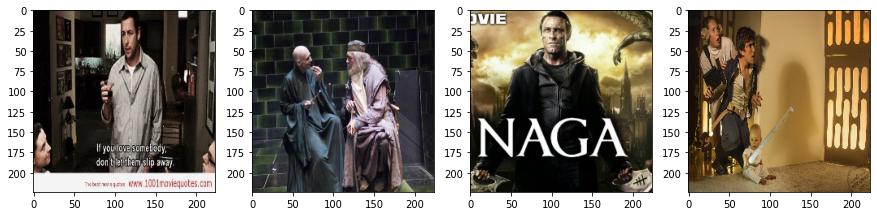

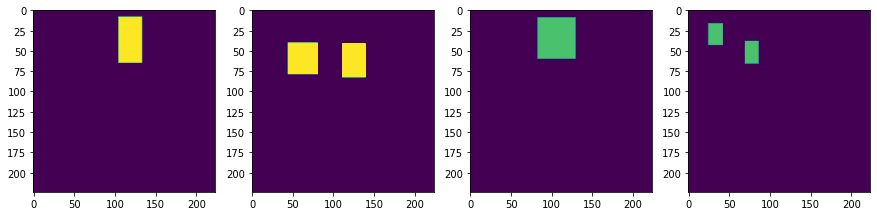

In [68]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow((X_train[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow((X_train[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow((X_train[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow((X_train[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow((y_train[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow((y_train[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow((y_train[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow((y_train[3]))
imgplot.set_clim(0.0, 1.4)

In [69]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64, 128]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [70]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [71]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( 
      #rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator() 

train_batchsize = 10
val_batchsize = 10
 
train_generator = train_datagen.flow( 
        X_train,y_train,
        batch_size=train_batchsize,shuffle=False)
 
validation_generator = validation_datagen.flow(
        X_valid,y_valid,
        batch_size=val_batchsize,
        shuffle=False)


In [72]:
model = model()
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [76]:
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath='mdl_mobilenet_callback.hdf5',
    save_weights_only=True,
    monitor='val_dice_coef',
    mode='max',
    save_best_only=True)


history= model.fit(    x=X_train,    y=y_train,    batch_size=32,       epochs=10,
                   validation_data=(X_valid, y_valid),
                   callbacks=[model_checkpoint_callback]    )

Train on 347 samples, validate on 62 samples
Epoch 1/10
347/347 [==============================] - 237s 682ms/sample - loss: 0.5844 - dice_coef: 0.4169 - recall_1: 0.8321 - precision_1: 0.4011 - val_loss: 0.7272 - val_dice_coef: 0.2725 - val_recall_1: 0.9999 - val_precision_1: 0.1442
Epoch 2/10
347/347 [==============================] - 225s 647ms/sample - loss: 0.5117 - dice_coef: 0.4887 - recall_1: 0.8699 - precision_1: 0.4787 - val_loss: 0.7051 - val_dice_coef: 0.2946 - val_recall_1: 0.9956 - val_precision_1: 0.1715
Epoch 3/10
347/347 [==============================] - 224s 645ms/sample - loss: 0.4781 - dice_coef: 0.5223 - recall_1: 0.8796 - precision_1: 0.5275 - val_loss: 0.7017 - val_dice_coef: 0.2980 - val_recall_1: 0.9938 - val_precision_1: 0.1870
Epoch 4/10
347/347 [==============================] - 223s 642ms/sample - loss: 0.4517 - dice_coef: 0.5477 - recall_1: 0.8850 - precision_1: 0.5676 - val_loss: 0.6645 - val_dice_coef: 0.3352 - val_recall_1: 0.9788 - val_precision_1: 0.

history = model.fit_generator(
      train_generator,
      steps_per_epoch=int(X_train.shape[0]/train_generator.batch_size) ,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=int(X_valid.shape[0]/validation_generator.batch_size),
      callbacks=[model_checkpoint_callback] 
)

In [77]:
#Save weights
from tensorflow.keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("part1_model1_mobilenet.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("part1_model1_mobilenet.h5")
print("Saved model to disk")

Saved model to disk


In [78]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

import numpy as np

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.3).astype(np.uint8)

62/62 [==============================] - 7s 108ms/sample


In [79]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

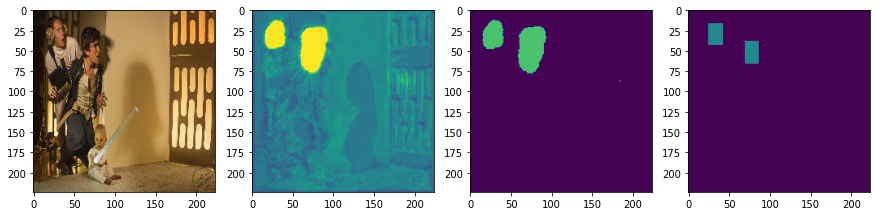

In [100]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow((X_train[3]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(preds_train[3])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(preds_train_t[3])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(y_train[3])
imgplot.set_clim(0.0, 2.1)


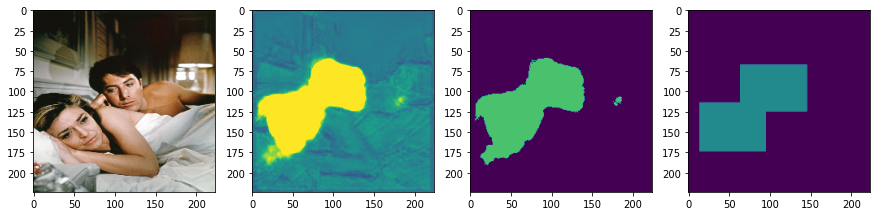

In [101]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot =plt.imshow(X_valid[50])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(preds_val[50])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(preds_val_t[50])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(y_valid[50])
imgplot.set_clim(0.0, 2.1)

In [93]:
test_img = os.path.join('F:/GreatLearning/AI/ComputerVision/Project2/Part1/Part 1Test Data - Prediction Image.jpeg' )

img = cv2.imread(test_img, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (im_size, im_size))#, interpolation = cv2.INTER_AREA)
    

In [95]:
image_batch = np.expand_dims(img, axis=0)
processed_image=image_batch/255

In [96]:
test_pred=model.predict(processed_image)

In [102]:
test_pred_t = (test_pred > 0.5).astype(np.uint8)

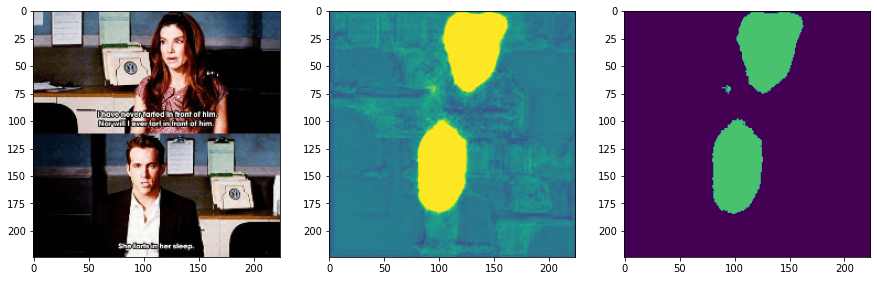

In [103]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 3, 1)
imgplot =plt.imshow(processed_image[0])

a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(test_pred[0])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 3, 3)
imgplot = plt.imshow(test_pred_t[0])
imgplot.set_clim(0.0, 1.4)

- We can observe the model is able to identify the faces